In [67]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import json
import pprint

import matplotlib.pyplot as plt
import numpy as np

detector_path = '..'
sys.path.append(detector_path)

from sleep.mass import MASS
from evaluation import data_manipulation
from sleep import data_ops
from sleep import postprocessing
from utils import param_keys
from evaluation import metrics

SEED = 123

In [10]:
def get_border_size(my_p):
    border_duration = my_p[param_keys.BORDER_DURATION]
    fs = my_p[param_keys.FS]
    border_size = fs * border_duration
    return border_size


def get_page_size(my_p):
    page_duration = my_p[param_keys.PAGE_DURATION]
    fs = my_p[param_keys.FS]
    page_size = fs * page_duration
    return page_size


def prepare_labels(y, params):
    """Ensures that label data has the proper shape."""
    time_stride = params[param_keys.TIME_RESOLUTION_FACTOR]
    border_size = get_border_size(params)
    page_size = get_page_size(params)
    crop_size = page_size + 2 * border_size
    if y.shape[1] == crop_size:
        # We need to remove borders and downsampling for val labels.
        y = y[:, border_size:-border_size:time_stride]
    return y

In [83]:
results_dir = os.path.join('..', 'results')
ckpt_folder = 'grid_20181216/loss_cross_entropy_loss_opt_adam_optimizer_lr_4_m_0.0_batch_32_trainwave_1_drop_0.3'
# ckpt_folder = 'grid_20181217/loss_cross_entropy_loss_opt_adam_optimizer_lr_3_m_0.0_batch_32_trainwave_0_drop_0.3'

ckpt_path = os.path.join(results_dir, ckpt_folder)

# Load data
dataset = MASS(load_checkpoint=True)

params = param_keys.default_params.copy()

print('Restoring from %s' % ckpt_path)

# Get training set ids
print('Loading training set and splitting')
all_train_ids = dataset.train_ids
# Split to form validation set
train_ids, val_ids = data_manipulation.split_ids_list(
    all_train_ids, seed=SEED)
print('Training set IDs:', train_ids)
print('Validation set IDs:', val_ids)

# Get test data
print('Loading testing')
test_ids = dataset.test_ids
print('Testing set IDs:', test_ids)

# Get data for predictions
augmented_page = False
which_expert = 1

border_size = get_border_size(params)
x_train, y_train = dataset.get_subset_data(
    train_ids, augmented_page=augmented_page, border_size=border_size,
    which_expert=which_expert, verbose=True)
pages_train = dataset.get_subset_pages(train_ids, verbose=True)

x_val, y_val = dataset.get_subset_data(
    val_ids, augmented_page=augmented_page, border_size=border_size,
    which_expert=which_expert, verbose=True)
pages_val = dataset.get_subset_pages(val_ids, verbose=True)

x_test, y_test = dataset.get_subset_data(
    test_ids, augmented_page=augmented_page, border_size=border_size,
    which_expert=which_expert, verbose=True)
pages_test = dataset.get_subset_pages(test_ids, verbose=True)

y_train = [prepare_labels(y, params) for y in y_train]
y_val = [prepare_labels(y, params) for y in y_val]
y_test = [prepare_labels(y, params) for y in y_test]

# We keep each patient separate, to see variation of performance
# between individuals
save_dir = os.path.join(results_dir, 'predictions', ckpt_folder)
y_pred_train = np.load(os.path.join(save_dir, 'y_pred_train.npy'))
y_pred_val = np.load(os.path.join(save_dir, 'y_pred_val.npy'))
y_pred_test = np.load(os.path.join(save_dir, 'y_pred_test.npy'))

# Keep only class 1 probability
y_pred_train = [y[..., 1] for y in y_pred_train]
y_pred_val = [y[..., 1] for y in y_pred_val]
y_pred_test = [y[..., 1] for y in y_pred_test]

print('Predictions Loaded')

# Threshold to binarize
thr = 0.5
y_pred_train = [(y >= 0.5).astype(np.int32) for y in y_pred_train]
y_pred_val = [(y >= 0.5).astype(np.int32) for y in y_pred_val]
y_pred_test = [(y >= 0.5).astype(np.int32) for y in y_pred_test]

# Compute by sample stats
y_train_flatten = np.concatenate(y_train, axis=0).flatten()
y_pred_train_flatten = np.concatenate(y_pred_train, axis=0).flatten()

y_val_flatten = np.concatenate(y_val, axis=0).flatten()
y_pred_val_flatten = np.concatenate(y_pred_val, axis=0).flatten()

y_test_flatten = np.concatenate(y_test, axis=0).flatten()
y_pred_test_flatten = np.concatenate(y_pred_test, axis=0).flatten()

bs_train = metrics.by_sample_confusion(y_train_flatten, y_pred_train_flatten, input_is_binary=True)
bs_val = metrics.by_sample_confusion(y_val_flatten, y_pred_val_flatten, input_is_binary=True)
bs_test = metrics.by_sample_confusion(y_test_flatten, y_pred_test_flatten, input_is_binary=True)

print('Train BS stats')
pprint.pprint(bs_train)

print('Val BS stats')
pprint.pprint(bs_val)

print('Test BS stats')
pprint.pprint(bs_test)

Dataset mass with 14 patients.
Train size: 10. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 19]
Test subjects: 
 [2, 6, 12, 13]
Loading from checkpoint
Loaded
Restoring from ../results/grid_20181216/loss_cross_entropy_loss_opt_adam_optimizer_lr_4_m_0.0_batch_32_trainwave_1_drop_0.3
Loading training set and splitting
Split IDs: Total 10 -- Training 8
Training set IDs: [9, 1, 14, 10, 17, 7, 3, 11]
Validation set IDs: [19, 5]
Loading testing
Testing set IDs: [2, 6, 12, 13]
Getting ID 9, 739 N2 pages, Expert 1
Getting ID 1, 745 N2 pages, Expert 1
Getting ID 14, 730 N2 pages, Expert 1
Getting ID 10, 696 N2 pages, Expert 1
Getting ID 17, 797 N2 pages, Expert 1
Getting ID 7, 694 N2 pages, Expert 1
Getting ID 3, 496 N2 pages, Expert 1
Getting ID 11, 638 N2 pages, Expert 1
Getting ID 9, 739 N2 pages
Getting ID 1, 745 N2 pages
Getting ID 14, 730 N2 pages
Getting ID 10, 696 N2 pages
Getting ID 17, 797 N2 pages
Getting ID 7, 694 N2 pages
Getting ID 3, 496 N2 pages
Getting ID 11, 

In [84]:
# Now we need to concatenate the pages and transform to intervals
y_train = [data_ops.seq2inter_with_pages(y, pages) for y, pages in zip(y_train, pages_train)]
y_pred_train = [data_ops.seq2inter_with_pages(y, pages) for y, pages in zip(y_pred_train, pages_train)]

y_val = [data_ops.seq2inter_with_pages(y, pages) for y, pages in zip(y_val, pages_val)]
y_pred_val = [data_ops.seq2inter_with_pages(y, pages) for y, pages in zip(y_pred_val, pages_val)]

y_test = [data_ops.seq2inter_with_pages(y, pages) for y, pages in zip(y_test, pages_test)]
y_pred_test = [data_ops.seq2inter_with_pages(y, pages) for y, pages in zip(y_pred_test, pages_test)]

In [86]:
fs_effect = int(params[param_keys.FS] / params[param_keys.TIME_RESOLUTION_FACTOR])
fs_effect

25

In [87]:
def post_process(marks, fs, delta_combine=0.3, min_duration=0.2, max_duration=4.0):
    marks = postprocessing.combine_close_marks(marks, fs, delta_combine)
    marks = postprocessing.filter_duration_marks(marks, fs, min_duration, max_duration)
    return marks


y_pred_train = [post_process(y, fs_effect) for y in y_pred_train]
y_pred_val = [post_process(y, fs_effect) for y in y_pred_val]
y_pred_test = [post_process(y, fs_effect) for y in y_pred_test]

In [88]:
be_train = [metrics.by_event_confusion(y, y_pred, iou_thr=0.2) for y, y_pred in zip(y_train, y_pred_train)]
be_val = [metrics.by_event_confusion(y, y_pred, iou_thr=0.2) for y, y_pred in zip(y_val, y_pred_val)]
be_test = [metrics.by_event_confusion(y, y_pred, iou_thr=0.2) for y, y_pred in zip(y_test, y_pred_test)]

print('BE train stats')
pprint.pprint(be_train)

print('BE val stats')
pprint.pprint(be_val)

print('BE test stats')
pprint.pprint(be_test)

BE train stats
[{'f1_score': 0.24759871931696908,
  'mean_all_iou': 0.07547677424198995,
  'mean_nonzero_iou': 0.5027626449507762,
  'n_detections': 131,
  'n_events': 806,
  'precision': 0.8854961832061069,
  'recall': 0.14392059553349876,
  'tp': 116},
 {'f1_score': 0.8559754851889683,
  'mean_all_iou': 0.6625446817173977,
  'mean_nonzero_iou': 0.8230417824198223,
  'n_detections': 917,
  'n_events': 1041,
  'precision': 0.9138495092693566,
  'recall': 0.8049951969260326,
  'tp': 838},
 {'f1_score': 0.8276816608996539,
  'mean_all_iou': 0.6776026632695313,
  'mean_nonzero_iou': 0.7943134898861895,
  'n_detections': 744,
  'n_events': 701,
  'precision': 0.803763440860215,
  'recall': 0.8530670470756063,
  'tp': 598},
 {'f1_score': 0.8862350722815839,
  'mean_all_iou': 0.7137243996038719,
  'mean_nonzero_iou': 0.8028134026749937,
  'n_detections': 798,
  'n_events': 793,
  'precision': 0.8834586466165414,
  'recall': 0.8890290037831021,
  'tp': 705},
 {'f1_score': 0.7817969661610268,


In [89]:
print('Train Mean F1 score: %1.4f' % np.mean([m['f1_score'] for m in be_train]))
print('Val Mean F1 score: %1.4f' % np.mean([m['f1_score'] for m in be_val]))
print('Test Mean F1 score: %1.4f' % np.mean([m['f1_score'] for m in be_test]))

Train Mean F1 score: 0.7100
Val Mean F1 score: 0.7654
Test Mean F1 score: 0.7495


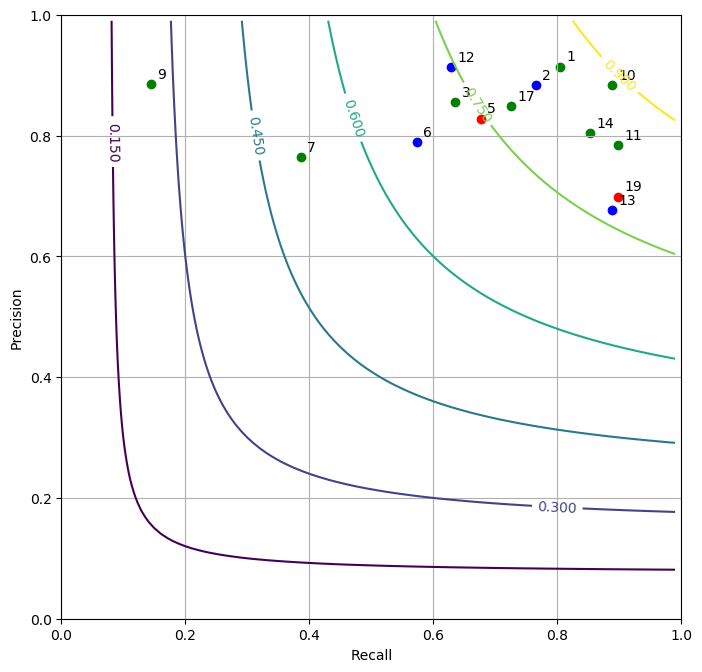

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=100)

# Training results
for i, stats in enumerate(be_train):
    ax.scatter(stats['recall'], stats['precision'], c='g')
    ax.annotate(train_ids[i], (stats['recall']+0.01, stats['precision']+0.01))
    
# Validation results
for i, stats in enumerate(be_val):
    ax.scatter(stats['recall'], stats['precision'], c='r')
    ax.annotate(val_ids[i], (stats['recall']+0.01, stats['precision']+0.01))
    
# Testing results
for i, stats in enumerate(be_test):
    ax.scatter(stats['recall'], stats['precision'], c='b')
    ax.annotate(test_ids[i], (stats['recall']+0.01, stats['precision']+0.01))
    

delta = 0.01 
x_ = np.arange(1, 100) * delta 
y_ = np.arange(1, 100) * delta 
X, Y = np.meshgrid(x_, y_)
Z = 2 * X * Y / (X + Y)

CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.show()